# Pre-process

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("final.csv",low_memory=False)

In [3]:
# Drop the columns with "Quality" and other columns you don't need
df = df.drop(['Timestamp', 'X Value', 'Y Value', 'Z Value'] + [col for col in df.columns if 'Quality' in col], axis=1)

In [4]:
# Step 1: Data Cleaning
# Handle missing or corrupted values

# Replace missing values with the mean of the column
df = df.replace("-", np.nan)
df = df.fillna(df.mean(numeric_only=True))

In [5]:
df.drop_duplicates(inplace=True)
df = df.dropna()

## Min-Max Scaling

In [6]:
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

df.to_csv('after_pre.csv', index=False)

## ICA

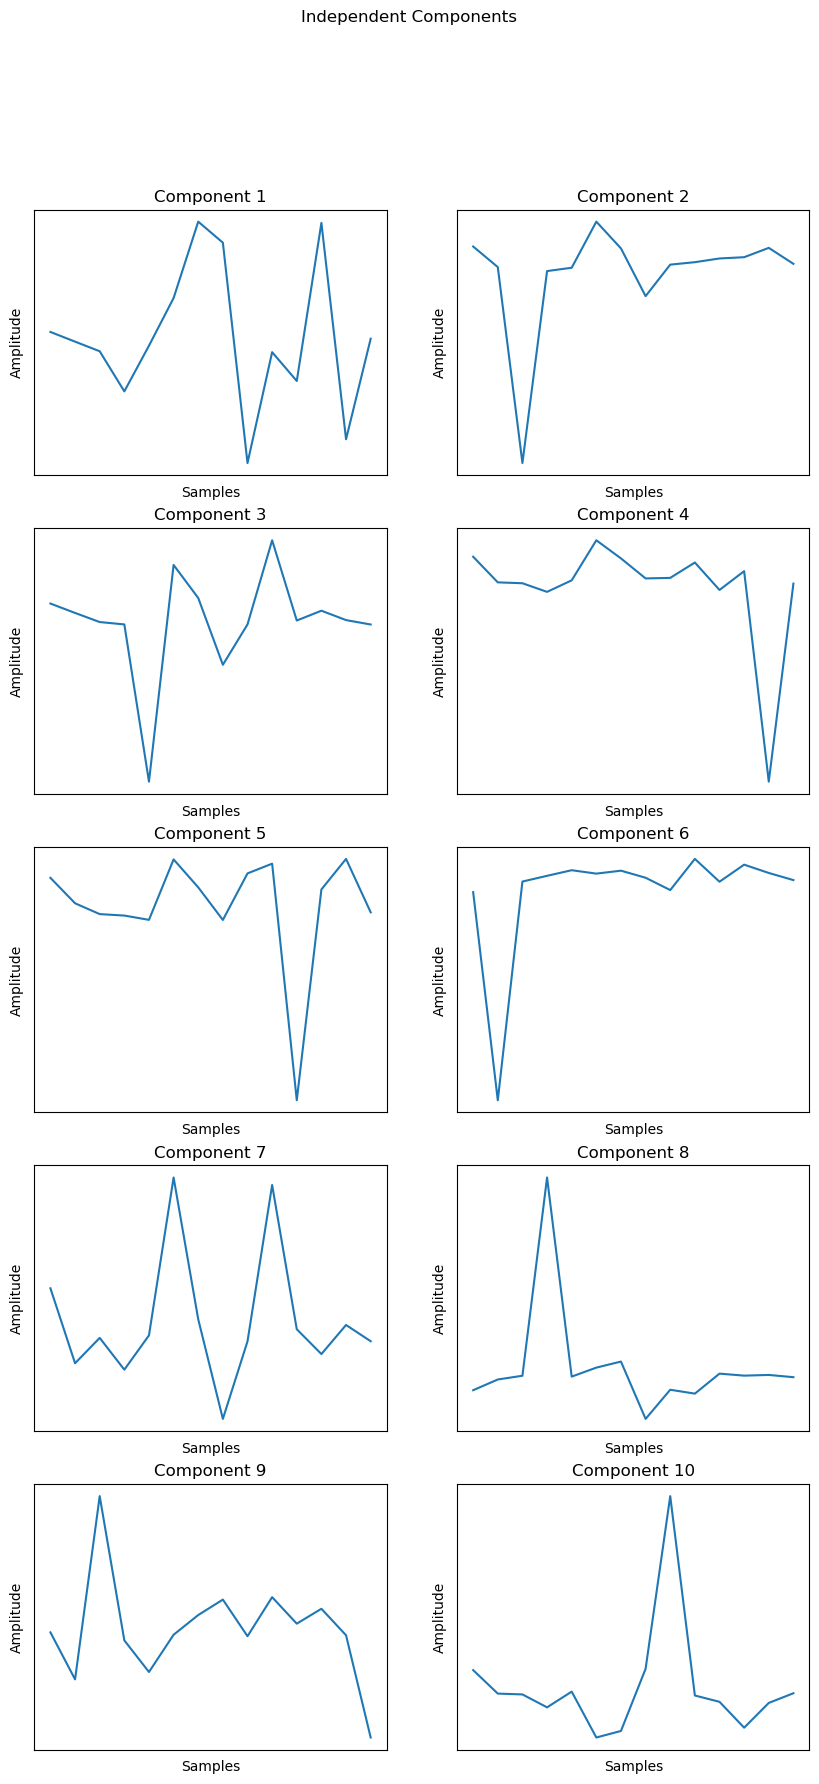

In [7]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

# Load the preprocessed EEG data into a NumPy array
X = np.array(df)

# Create an ICA object with the desired number of components
ica = FastICA(n_components=10)

# Fit the ICA model to the EEG data
ica.fit(X)

# Use the ICA model to transform the EEG data
X_ica = ica.transform(X)

# Plot the ICA components
fig, axes = plt.subplots(5, 2, figsize=(10,20))
fig.suptitle('Independent Components')
for i, ax in enumerate(axes.flat):
    ax.plot(ica.components_[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('Samples')
    ax.set_ylabel('Amplitude')
    ax.set_title('Component {}'.format(i+1))
plt.show()


In [8]:
import mne
import numpy as np

# Load the preprocessed EEG data into a NumPy array
y = df.iloc[:,:-1]
target = df.iloc[:,-1]
X = np.array(y)

# Create an MNE-Python Raw object with the EEG data
ch_names = [f'ch{i}' for i in range(X.shape[1])]
ch_types = ['eeg'] * (X.shape[1])


info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
raw = mne.io.RawArray(X.transpose(), info)

# Apply a high-pass filter to the raw data
raw.filter(l_freq=1.0, h_freq=None)

print(info)


Creating RawArray with float64 data, n_channels=13, n_times=180987
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

<Info | 7 non-empty values
 bads: []
 ch_names: ch0, ch1, ch2, ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12
 chs: 13 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 13
 projs: []
 sfreq: 250.0 Hz
>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


In [9]:
# Create an ICA object with the desired number of components
n_components = 10
ica = mne.preprocessing.ICA(n_components=n_components, random_state=0)

# Fit the ICA model to the EEG data
ica.fit(raw)

# Plot the independent components
#ica.plot_components()

Fitting ICA to data using 13 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 2.5s.


Method,fastica
Fit,37 iterations on raw data (180987 samples)
ICA components,10
Available PCA components,13
Channel types,eeg
ICA components marked for exclusion,—


In [10]:
# Apply ICA to raw data and get cleaned data
ica_data = ica.apply(raw)

print(ica_data)
ica = ica_data.get_data()
print(ica.shape)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 0 ICA components
    Projecting back using 13 PCA components
<RawArray | 13 x 180987 (723.9 s), ~18.0 MB, data loaded>
(13, 180987)


In [11]:
# Create a new MNE-Python Raw object with the cleaned data
clean_info = raw.info.copy()
clean_raw = mne.io.RawArray(ica, clean_info)

dat = clean_raw.get_data()
print(dat.shape)
# Save the cleaned data to a file
clean_raw.save('cleaned_data_raw.fif',overwrite=True)

Creating RawArray with float64 data, n_channels=13, n_times=180987
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
(13, 180987)
Overwriting existing file.
Writing C:\Users\Tilak Chan\OneDrive\Desktop\Tilak\BagOfLies\New_\cleaned_data_raw.fif
Closing C:\Users\Tilak Chan\OneDrive\Desktop\Tilak\BagOfLies\New_\cleaned_data_raw.fif
[done]


## MNE

Opening raw data file cleaned_data_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
Using matplotlib as 2D backend.


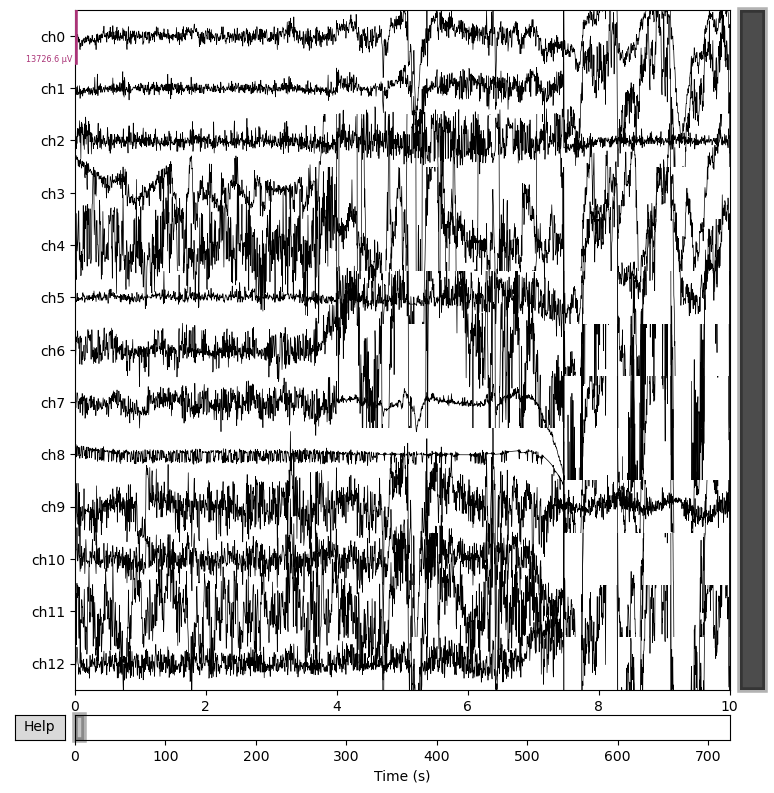

[]


In [12]:
import mne

# Load the cleaned data into an MNE-Python Raw object
raw = mne.io.read_raw_fif('cleaned_data_raw.fif',preload=True)

# Plot raw data before pre-processing
raw.plot(n_channels=13, scalings='auto', title='Before Pre-processing')

# Apply pre-processing steps
# Check for bad channels and remove if necessary
print(raw.info['bads'])

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 40 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 83 samples (0.332 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.2s finished


(13, 180987)


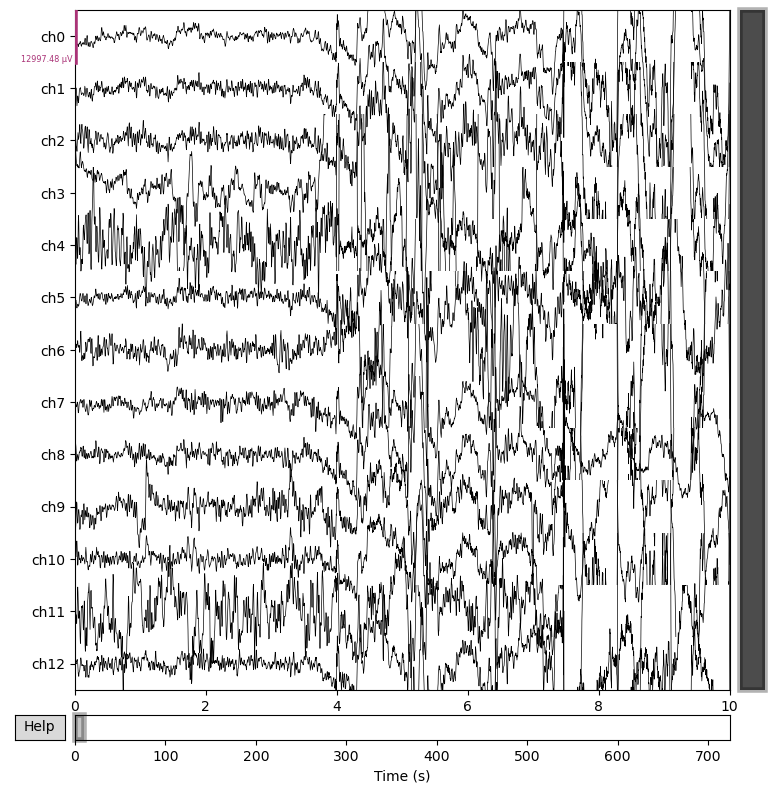

(13, 180987)


In [13]:
# Set the reference to average
raw.set_eeg_reference('average')

# Apply a notch filter to remove power line noise at 50 Hz and its harmonics
clean_raw = raw.copy().filter(l_freq=100.0, h_freq=40.0, picks='eeg', method='fir', phase='zero', fir_window='hamming', fir_design='firwin')

dat = clean_raw.get_data()
print(dat.shape)
# Downsample the data to 100 Hz
#clean_raw.resample(sfreq=200)


# Plot raw data after pre-processing
clean_raw.plot(n_channels=13, scalings='auto', title='After Pre-processing')
dat = clean_raw.get_data()
print(dat.shape)

In [14]:
target = np.array(target)
print(target.shape)

n_samples = clean_raw.n_times
print(n_samples)
target = target[:n_samples]

(180987,)
180987


## Feature Extraction using MNE

In [15]:
raw = clean_raw

# Set frequency bands of interest
freq_bands = {'Delta': [1, 4],
              'Theta': [4, 8],
              'Alpha': [8, 12],
              'Beta': [12, 30],
              'Gamma': [30, 45]}

# Extract spectral features
psd, freqs = mne.time_frequency.psd_array_welch(raw._data, sfreq=raw.info['sfreq'], fmin=0, fmax=raw.info['sfreq']/2)

# extract spectral features for each frequency band
features = dict()
for band, (fmin, fmax) in freq_bands.items():
    idx = (freqs >= fmin) & (freqs < fmax)
    band_psd = psd[:, idx].mean(axis=1)
    features[band] = band_psd

# Add spectral features to raw object
ch_names = [ch_name for ch_name in raw.ch_names if ch_name.startswith('EEG')]
for i, ch_name in enumerate(ch_names):
    raw.set_channel_types({ch_name: 'eeg'})
    for j, (band, freq_range) in enumerate(freq_bands.items()):
        raw.info['chs'][i]['ch_names'].append(f'{band} ({freq_range[0]}-{freq_range[1]} Hz)')
        raw._data[i] = np.vstack((raw._data[i], spectral_features[:, j]))

# Save raw object with spectral features
raw.save('spectral_features_raw.fif',overwrite=True)

Effective window size : 1.024 (s)
Overwriting existing file.
Writing C:\Users\Tilak Chan\OneDrive\Desktop\Tilak\BagOfLies\New_\spectral_features_raw.fif
Closing C:\Users\Tilak Chan\OneDrive\Desktop\Tilak\BagOfLies\New_\spectral_features_raw.fif
[done]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Opening raw data file spectral_features_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


C:\Users\Tilak Chan\anaconda3\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


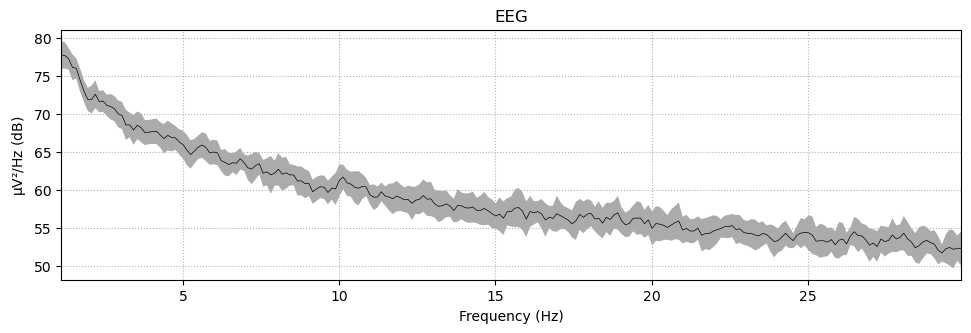

In [16]:
# Load the spectral features
spectral_features_raw = mne.io.read_raw_fif('spectral_features_raw.fif', preload=True)

# Plot the power spectral density (PSD)
fig = spectral_features_raw.plot_psd(fmin=1, fmax=30, tmax=None, average=True, spatial_colors=False)
plt.savefig('figure.png')
plt.show()

## Random Forest

In [26]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the spectral features data
data = mne.io.read_raw_fif('spectral_features_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target

print(X.shape)
print(y.shape)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set and compute accuracy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))


Opening raw data file spectral_features_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
(180987, 13)
(180987,)
Accuracy: 86.10%


In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Load the spectral features data
data = mne.io.read_raw_fif('spectral_features_raw.fif', preload=True)
X = data.get_data()
X = X.transpose()
y = target

print(X.shape)
print(y.shape)

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train a random forest classifier on each fold and compute accuracy
accs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestClassifier(n_estimators=100, random_state=42,verbose=1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

# Compute the mean accuracy and standard deviation across all folds
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print("Mean accuracy: {:.2f}%".format(mean_acc * 100))
print("Standard deviation: {:.2f}%".format(std_acc * 100))

Opening raw data file spectral_features_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
(180987, 13)
(180987,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Mean accuracy: 85.77%
Standard deviation: 0.20%


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


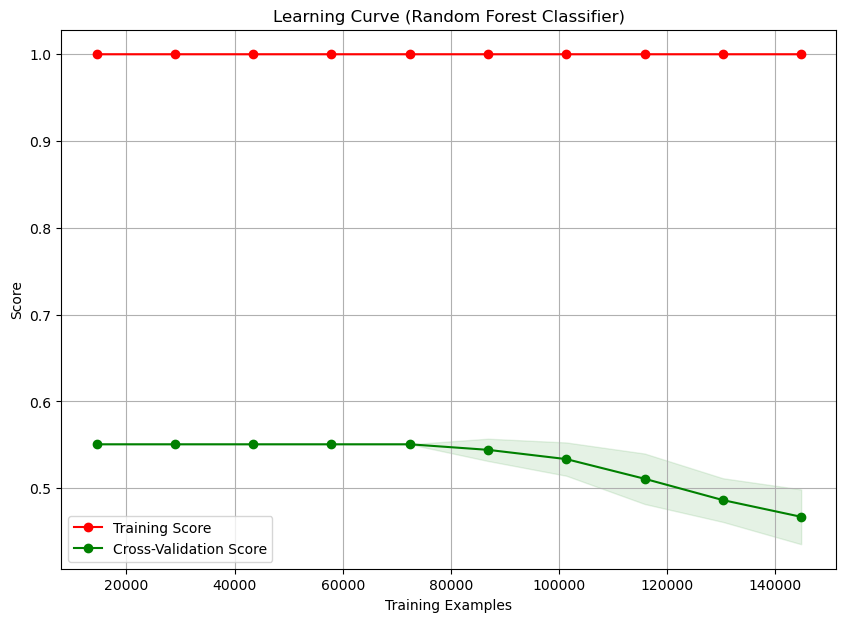

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Define the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the range of training set sizes to use for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 7))
plt.title("Learning Curve (Random Forest Classifier)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except the last one
y = df.iloc[:, -1]   # the last column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=45)

# Create the random forest classifier with default hyperparameters
rfc = RandomForestClassifier()

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rfc.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 score: {:.2f}".format(f1))

Accuracy: 0.90
Precision: 0.89
Recall: 0.94
F1 score: 0.91


# Decision tree

In [24]:
# import the necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# create a Decision Tree Classifier object
dtc = DecisionTreeClassifier()

data = mne.io.read_raw_fif('spectral_features_raw.fif',preload=True)
X = data.get_data()
X = X.transpose()
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the classifier on the training data
dtc.fit(X_train, y_train)

# use the trained classifier to predict the labels of the test data
y_pred = dtc.predict(X_test)

# calculate the accuracy, precision, and recall of the classifier
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)

Opening raw data file spectral_features_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
Accuracy: 0.7228023647715344
Precision: 0.745605223505776
Recall: 0.7492177248410214


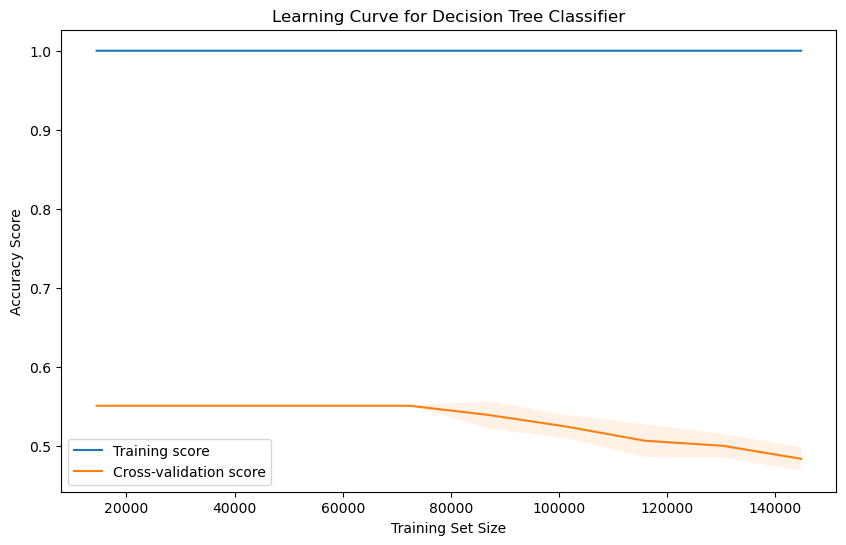

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Create a Decision Tree classifier
tree = DecisionTreeClassifier()

# Define the range of training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve scores for the training and validation sets
train_sizes, train_scores, valid_scores = learning_curve(tree, X, y, train_sizes=train_sizes, cv=5)

# Compute the mean and standard deviation of the training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, valid_mean, label='Cross-validation score')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1)
plt.title('Learning Curve for Decision Tree Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.show()

# Gradient-Boosting

In [28]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the spectral features data
data = mne.io.read_raw_fif('spectral_features_raw.fif', preload=True)
X = data.get_data().transpose()
y = target

print(X.shape)
print(y.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Train a gradient boosting classifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set and compute accuracy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Opening raw data file spectral_features_raw.fif...
Isotrak not found
    Range : 0 ... 180986 =      0.000 ...   723.944 secs
Ready.
Reading 0 ... 180986  =      0.000 ...   723.944 secs...
(180987, 13)
(180987,)
Accuracy: 60.66%


[learning_curve] Training set sizes: [ 14478  28957  43436  57915  72394  86873 101352 115831 130310 144789]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.4min finished


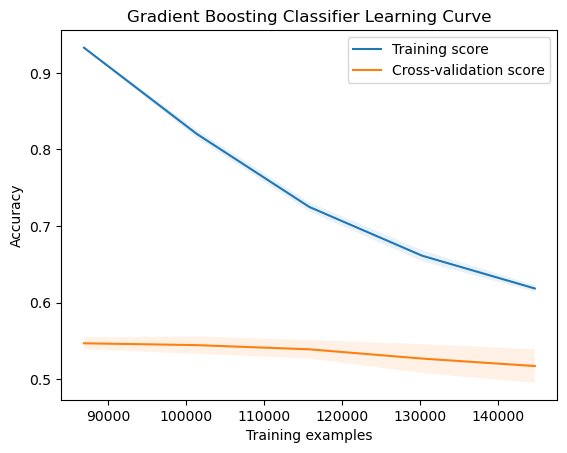

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    GradientBoostingClassifier(n_estimators=100, random_state=42), X, y,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), verbose=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Gradient Boosting Classifier Learning Curve")
plt.show()

# Neural Networks

In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD

# Load the data
data = df

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2,stratify=y)

# Separate the target variable
train_labels = train_data.pop('truth')
test_labels = test_data.pop('truth')

print(train_data.shape)

(144789, 13)


In [35]:
# Create a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[train_data.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=34, validation_data=(test_data, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

print('Test accuracy:', test_accuracy)

Epoch 1/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6882 - accuracy: 0.5494 - val_loss: 0.6879 - val_accuracy: 0.5507
Epoch 2/10
4259/4259 [==============================] - 8s 2ms/step - loss: 0.6879 - accuracy: 0.5507 - val_loss: 0.6879 - val_accuracy: 0.5507
Epoch 3/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6879 - accuracy: 0.5507 - val_loss: 0.6879 - val_accuracy: 0.5507
Epoch 4/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6879 - accuracy: 0.5507 - val_loss: 0.6879 - val_accuracy: 0.5507
Epoch 5/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6879 - accuracy: 0.5507 - val_loss: 0.6878 - val_accuracy: 0.5507
Epoch 6/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6878 - accuracy: 0.5507 - val_loss: 0.6878 - val_accuracy: 0.5507
Epoch 7/10
4259/4259 [==============================] - 9s 2ms/step - loss: 0.6878 - accuracy: 0.5507 - val_loss: 0.6878 - val_accuracy:

In [32]:
# Create a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=[train_data.shape[1]]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])


model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=2)
test_labels = tf.keras.utils.to_categorical(test_labels,num_classes=2)
# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=34, validation_data=(test_data, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

print('Test accuracy:', test_accuracy)


Epoch 1/10
4259/4259 [==============================] - 15s 3ms/step - loss: 0.6883 - accuracy: 0.5506 - val_loss: 0.6880 - val_accuracy: 0.5507
Epoch 2/10
4259/4259 [==============================] - 14s 3ms/step - loss: 0.6880 - accuracy: 0.5508 - val_loss: 0.6878 - val_accuracy: 0.5510
Epoch 3/10
4259/4259 [==============================] - 14s 3ms/step - loss: 0.6879 - accuracy: 0.5508 - val_loss: 0.6879 - val_accuracy: 0.5508
Epoch 4/10
4259/4259 [==============================] - 14s 3ms/step - loss: 0.6879 - accuracy: 0.5508 - val_loss: 0.6880 - val_accuracy: 0.5507
Epoch 5/10
4259/4259 [==============================] - 15s 3ms/step - loss: 0.6880 - accuracy: 0.5508 - val_loss: 0.6879 - val_accuracy: 0.5508
Epoch 6/10
4259/4259 [==============================] - 15s 3ms/step - loss: 0.6879 - accuracy: 0.5508 - val_loss: 0.6881 - val_accuracy: 0.5508
Epoch 7/10
4259/4259 [==============================] - 15s 4ms/step - loss: 0.6880 - accuracy: 0.5508 - val_loss: 0.6879 - val_ac

In [37]:
# Create a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=[train_data.shape[1]]),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])


model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=2)
test_labels = tf.keras.utils.to_categorical(test_labels,num_classes=2)
# Train the model
model.fit(train_data, train_labels, epochs=10, batch_size=34, validation_data=(test_data, test_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

print('Test accuracy:', test_accuracy)


Epoch 1/10
4259/4259 [==============================] - 18s 4ms/step - loss: 0.6883 - accuracy: 0.5504 - val_loss: 0.6880 - val_accuracy: 0.5507
Epoch 2/10
4259/4259 [==============================] - 17s 4ms/step - loss: 0.6881 - accuracy: 0.5506 - val_loss: 0.6879 - val_accuracy: 0.5508
Epoch 3/10
4259/4259 [==============================] - 18s 4ms/step - loss: 0.6880 - accuracy: 0.5508 - val_loss: 0.6878 - val_accuracy: 0.5509
Epoch 4/10
4259/4259 [==============================] - 18s 4ms/step - loss: 0.6881 - accuracy: 0.5509 - val_loss: 0.6879 - val_accuracy: 0.5509
Epoch 5/10
4259/4259 [==============================] - 18s 4ms/step - loss: 0.6879 - accuracy: 0.5509 - val_loss: 0.6878 - val_accuracy: 0.5511
Epoch 6/10
4259/4259 [==============================] - 20s 5ms/step - loss: 0.6879 - accuracy: 0.5509 - val_loss: 0.6879 - val_accuracy: 0.5508
Epoch 7/10
4259/4259 [==============================] - 22s 5ms/step - loss: 0.6879 - accuracy: 0.5509 - val_loss: 0.6879 - val_ac

In [30]:
256*2

512